# Linear models, loss functions, gradients, SGD
(c) Deniz Yuret, 2019

TODO: review
* Objectives: Define, train and visualize a simple model; understand gradients and SGD; learn to use the GPU.
* Prerequisites: [Callable objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1), [Generator expressions](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions-1), [MNIST data](02.mnist.ipynb)
* AutoGrad: Param, @diff, value, params (used and explained)
* Knet: accuracy, zeroone, nll, train! (defined and explained)
* Knet: gpu, KnetArray (used and explained)
* Knet: dir, minibatch (used by mnist.jl)
* Knet: load, save (used by the experiment)

In [97]:
# Load packages, set display, import symbols
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
ENV["COLUMNS"]=72
using Knet: Knet, dir, Data, nll, Param, @diff, value, params, grad, progress, gpu, load, save, KnetArray

In [98]:
# Load data (mnistdata basically replicates 02.mnist.ipynb)
include(Knet.dir("data","mnist.jl"))
dtrn,dtst = mnistdata(xsize=(784,:),xtype=Array)
println.(summary.((dtrn,dtst)));

600-element Data{Tuple{Array{Float32,2},Array{UInt8,1}}}
100-element Data{Tuple{Array{Float32,2},Array{UInt8,1}}}


## Define linear model

In [99]:
# In Julia we define a new datatype using `struct`:
struct Linear; w; b; end

# The new struct comes with a default constructor:
model = Linear(0.01 * randn(10,784), zeros(10))

# We can define other constructors with different inputs:
Linear(i::Int,o::Int,scale=0.01) = Linear(scale * randn(o,i), zeros(o))

# This one allows instances to be defined using input and output sizes:
model = Linear(784,10)

Linear([-0.00377806 0.0110938 … 0.0198782 -0.00705759; 0.00534539 -0.00616606 … -0.000314636 -0.0127307; … ; 0.00176061 -0.0133343 … -0.0131596 -0.00748238; -0.0058436 0.0109101 … 0.00916474 0.00435537], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Prediction and accuracy

In [100]:
# We turn Linear instances into callable objects for prediction:
(m::Linear)(x) = m.w * x .+ m.b

In [101]:
# Let's take the first minibatch from the test set
x,y = first(dtst)
summary.((x,y))

("784×100 Array{Float32,2}", "100-element Array{UInt8,1}")

In [102]:
# Display its prediction on the first minibatch: a 10xN score matrix
ypred = model(x)

10×100 Array{Float64,2}:
  0.00327584   0.0351828   0.108583    …   0.0825835  -0.0204886
 -0.127875    -0.0519416  -0.0388196       0.0245466   0.0347951
 -0.0479252    0.0889705   0.0151341      -0.0401825  -0.0761551
 -0.0222685   -0.0266171  -0.0381848      -0.0726809   0.0806311
  0.140613    -0.0285919  -0.00238262      0.0856571   0.188903 
  0.0443382    0.169166    0.0536552   …   0.0859564  -0.0586721
 -0.0148961   -0.0225166   0.0164801      -0.0279884  -0.0750865
  0.0157848   -0.150964    0.0563503      -0.0785176  -0.0391828
 -0.0504642    0.0103322   0.0462494       0.034828   -0.0962569
 -0.1593      -0.0757939   0.015413        0.0699851   0.031979 

In [103]:
# correct answers are given as an array of integers
# (remember we use 10 for 0)
Int.(y)'

1×100 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 7  2  1  10  4  1  4  9  5  9  …  1  3  6  9  3  1  4  1  7  6  9

In [104]:
# We can calculate the accuracy of our model for the first minibatch
using Statistics: mean
accuracy(model,x,y) = mean(y' .== map(i->i[1], findmax(Array(model(x)),dims=1)[2]))
accuracy(model,x,y)

0.13

In [105]:
# We can calculate the accuracy of our model for the whole test set
accuracy(model,data::Data) = mean(accuracy(model,x,y) for (x,y) in data)
accuracy(model,dtst)

0.0892

In [106]:
# ZeroOne loss (or error) is defined as 1 - accuracy
zeroone(x...) = 1 - accuracy(x...)
zeroone(model,dtst)

0.9108

## Negative log likelihood

In [107]:
# With two inputs, let the model compute a loss. For classification we use
# negative log likelihood (aka cross entropy, softmax loss, NLL)
function (m::Linear)(x, y)
    scores = m(x)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    answerprobs = (probabilities[y[i],i] for i in 1:length(y))
    mean(-log.(answerprobs))
end

In [108]:
# Calculate loss of our model for the first minibatch
model(x,y)

2.2927706689153924

In [109]:
# We can also use the Knet nll implementation for efficiency
(m::Linear)(x, y) = nll(m(x), y)
model(x,y)

2.2927706689153924

In [110]:
# If the input is a dataset compute average loss:
(m::Linear)(data::Data) = mean(m(x,y) for (x,y) in data)

In [111]:
# Here is per-instance average negative log likelihood for the whole test set
model(dtst)

2.2975223307348633

## Calculating the gradient using AutoGrad

In [112]:
import AutoGrad
@doc AutoGrad

Usage:

```
x = Param([1,2,3])          # user declares parameters with `Param`
x => P([1,2,3])             # `Param` is just a struct wrapping a value
value(x) => [1,2,3]         # `value` returns the thing wrapped
sum(x .* x) => 14           # Params act like regular values
y = @diff sum(x .* x)       # Except when we differentiate using `@diff`
y => T(14)                  # you get another struct
value(y) => 14              # which carries the same result
params(y) => [x]            # and the Params that it depends on 
grad(y,x) => [2,4,6]        # and the gradients for all Params
```

`Param(x)` returns a struct that acts like `x` but marks it as a parameter you want to compute gradients with respect to.

`@diff expr` evaluates an expression and returns a struct that contains the result (which should be a scalar) and gradient information.

`grad(y, x)` returns the gradient of `y` (output by @diff) with respect to any parameter `x::Param`, or  `nothing` if the gradient is 0.

`value(x)` returns the value associated with `x` if `x` is a `Param` or the output of `@diff`, otherwise returns `x`.

`params(x)` returns an iterator of Params found by a recursive search of object `x`.

Alternative usage:

```
x = [1 2 3]
f(x) = sum(x .* x)
f(x) => 14
grad(f)(x) => [2 4 6]
gradloss(f)(x) => ([2 4 6], 14)
```

Given a scalar valued function `f`, `grad(f,argnum=1)` returns another function `g` which takes the same inputs as `f` and returns the gradient of the output with respect to the argnum'th argument. `gradloss` is similar except the resulting function also returns f's output.


In [16]:
# Redefine the constructor to use Param's so we can compute gradients
Linear(i::Int,o::Int,scale=0.01) = 
    Linear(Param(scale * randn(o,i)), Param(zeros(o)))

Linear

In [17]:
# Set random seed for replicability
using Random; Random.seed!(9);

In [18]:
# Use a larger scale to get a large initial loss
model = Linear(784,10,1.0)

Linear(P(Array{Float64,2}(10,784)), P(Array{Float64,1}(10)))

In [19]:
# We can still do predictions and calculate loss:
model(x,y)

19.10423456298375

In [20]:
# And we can do the same loss calculation also computing gradients:
J = @diff model(x,y)

T(19.10423456298375)

In [21]:
# To get the actual loss value from J:
value(J)

19.10423456298375

In [22]:
# params(J) returns an iterator of Params J depends on (i.e. model.b, model.w):
params(J) |> collect

2-element Array{Param,1}:
 P(Array{Float64,1}(10))    
 P(Array{Float64,2}(10,784))

In [23]:
# To get the gradient of a parameter from J:
∇w = grad(J,model.w)

10×784 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0

In [24]:
# Note that each gradient has the same size and shape as the corresponding parameter:
@show ∇b = grad(J,model.b);

∇b = grad(J, model.b) = [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576]


## Checking the gradient using numerical approximation

What does ∇b represent?

∇b[10] = 0.79 means if I increase b[10] by ϵ, loss will increase by 0.79ϵ

In [25]:
# Loss for the first minibatch with the original parameters
@show value(model.b)
model(x,y)

value(model.b) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


19.10423456298375

In [26]:
# To numerically check the gradient let's increase the last entry of b by +0.1.
model.b[10] = 0.1

0.1

In [27]:
# We see that the loss moves by ≈ +0.79*0.1 as expected.
@show value(model.b)
model(x,y)

value(model.b) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]


19.183620170313954

In [28]:
# Reset the change.
model.b[10] = 0

0

## Checking the gradient using manual implementation

In [29]:
# Without AutoGrad we would have to define the gradients manually:
function nllgrad(model,x,y)
    scores = model(x)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    for i in 1:length(y); probabilities[y[i],i] -= 1; end
    dJds = probabilities / length(y)
    dJdw = dJds * x'
    dJdb = vec(sum(dJds,dims=2))
    dJdw,dJdb
end;

In [30]:
∇w2,∇b2 = nllgrad(model,x,y)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576])

In [31]:
∇w2 ≈ ∇w

true

In [32]:
∇b2 ≈ ∇b

true

## Training with Stochastic Gradient Descent (SGD)

In [46]:
# Here is a single SGD update:
function sgdupdate!(func, args; lr=0.1)
    fval = @diff func(args...)
    for param in params(fval)
        ∇param = grad(fval, param)
        param .-= lr * ∇param
    end
    return value(fval)
end

sgdupdate! (generic function with 1 method)

In [73]:
# We define SGD for a dataset as an iterator so that:
# 1. We can monitor and report the training loss
# 2. We can take snapshots of the model during training
# 3. We can pause/terminate training when necessary
sgdtrain(func, data; lr=0.1) = (sgdupdate!(func, args; lr=lr) for args in data)

sgdtrain (generic function with 1 method)

In [74]:
# Let's train a model for 10 epochs and see if loss improves.
# progress!(itr) displays a progress bar when wrapped around an iterator.
model = Linear(784,10)
@show model(dtst)
progress!(sgdtrain(model, repeat(dtrn,10)))
@show model(dtst)

model(dtst) = 2.309235f0
2.94e-01  100.00%┣███████████████████┫ 6000/6000 [00:04-00:00, 1406.29/s]
model(dtst) = 0.28057584f0


0.28057584f0

## Using the GPU

In [113]:
# To work on the GPU, all we have to do is convert Arrays to KnetArrays:
if gpu() >= 0  # gpu() returns a device id >= 0 if there is a GPU, -1 otherwise
    atype = KnetArray{Float32}
    dtrn,dtst = mnistdata(xsize=(784,:),xtype=atype)
    Linear(i::Int,o::Int,scale=0.01) = 
        Linear(Param(atype(scale * randn(o,i))), 
               Param(atype(zeros(o))))

    model = Linear(784,10)
    @show model(dtst)
    progress!(sgdtrain(model,repeat(dtrn,10)))
    @show model(dtst)
end

model(dtst) = 2.2963555f0
2.94e-01  100.00%┣███████████████████┫ 6000/6000 [00:03-00:00, 1747.49/s]
model(dtst) = 0.28066075f0


0.28066075f0

## Recording progress

In [119]:
if (print("Train from scratch? (~77s) "); readline()[1]=='y')
    model = Linear(784,10)
    lin = []
    for (i,j) in enumerate(progress(sgdtrain(model,repeat(dtrn,100))))
        if i % length(dtrn) == 1
            push!(lin, deepcopy(model), model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
        end
    end
    lin = reshape(lin, (5,:))
    save("lin.jld2","results",lin)
else
    isfile("lin.jld2") || download("http://people.csail.mit.edu/deniz/models/tutorial/lin.jld2","lin.jld2")
    lin = load("lin.jld2","results")    
end

Train from scratch? (~77s) stdin> y
2.43e-01  100.00%┣█████████████████▉┫ 60000/60000 [01:15-00:00, 798.73/s]


## Linear model shows underfitting

In [120]:
using Plots; default(fmt = :png)

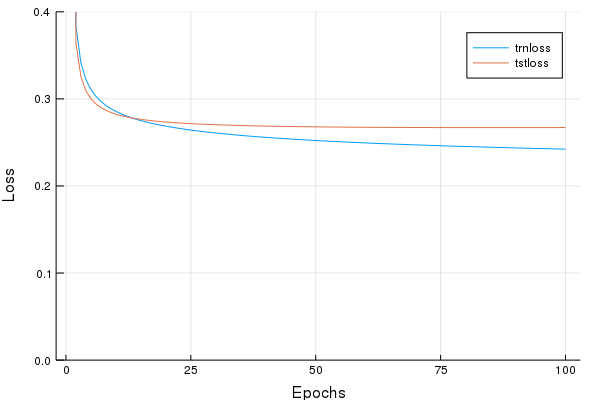

In [121]:
# Demonstrates underfitting: training loss not close to 0
# Also slight overfitting: test loss higher than train
plot([lin[2,:], lin[3,:]],ylim=(.0,.4),labels=[:trnloss :tstloss],xlabel="Epochs",ylabel="Loss")

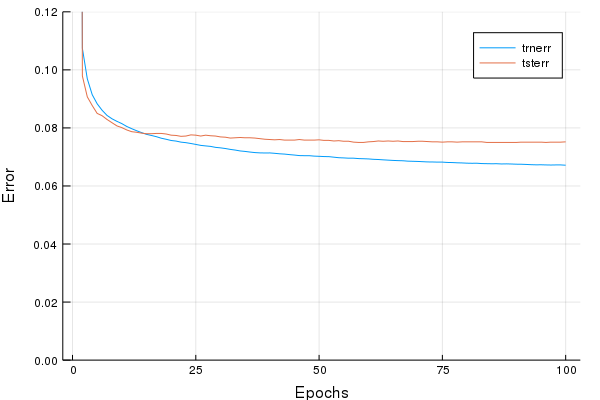

In [122]:
# this is the error plot, we get to about 7.5% test error, i.e. 92.5% accuracy
plot([lin[4,:], lin[5,:]],ylim=(.0,.12),labels=[:trnerr :tsterr],xlabel="Epochs",ylabel="Error")

## Visualizing the learned weights

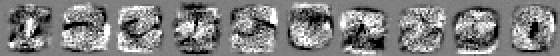

"Epoch 100"

In [123]:
# Let us visualize the evolution of the weight matrix as images below
# Each row is turned into a 28x28 image with positive weights light and negative weights dark gray
using Images, ImageMagick
for t in 10 .^ range(0,stop=log10(size(lin,2)),length=10) #logspace(0,2,20)
    i = floor(Int,t)
    f = lin[1,i]
    w1 = reshape(Array(value(f.w))', (28,28,1,10))
    w2 = clamp.(w1.+0.5,0,1)
    IJulia.clear_output(true)
    display(hcat([mnistview(w2,i) for i=1:10]...))
    display("Epoch $i")
    sleep(1) # (0.96^i)
end